In [1]:
import pandas as pd
import polars as pl
import numpy as np
import os
import gc
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer
import pickle

gc.enable()

pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

pl.Config.set_tbl_rows(-1)
pl.Config.set_tbl_cols(-1)
pl.Config.set_fmt_str_lengths(10000)

polars.config.Config

In [2]:
path = 'I:/Kaggle/jane-street-real-time-market-data-forecasting/'

In [3]:
first_items_list = os.listdir(path)

In [4]:
first_items_list

['features.csv',
 'kaggle_evaluation',
 'lags.parquet',
 'my_folder',
 'responders.csv',
 'sample_submission.csv',
 'test.parquet',
 'train.parquet']

In [5]:
# https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def reduce_mem_usage(df, float16_as32=True):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)!='category':
            c_min,c_max = df[col].min(),df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    if float16_as32:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float16) 
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df.copy()

In [6]:
def read_parquet_files(train_or_test='train'):
    pq_folders_path = path + f"{train_or_test}.parquet/"
    folders_list = os.listdir(pq_folders_path)

    pq_list = []
    
    for folder in tqdm(folders_list):
        files_path = pq_folders_path + '/' + folder
        files_list = os.listdir(files_path)
        for file in files_list:
            if '.parquet' in file:
                pq_df = pd.read_parquet(files_path + '/' + file)

                if train_or_test == 'train':
                    cols_to_drop = [col for col in pq_df.columns if 'responder' in col]
                    cols_to_drop.remove('responder_6')
                    pq_df = pq_df.drop(cols_to_drop, axis=1)
                
                pq_list.append(pq_df)

    return reduce_mem_usage(pd.concat(pq_list, ignore_index=True), False)

In [7]:
train_scan = pl.scan_parquet(path + 'train.parquet/')
test_scan = pl.scan_parquet(path + 'test.parquet/')

In [8]:
train_symbol_ids_list = sorted(train_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(train_symbol_ids_list))
train_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [9]:
test_symbol_ids_list = sorted(test_scan.select('symbol_id').unique().collect()['symbol_id'].to_list())
print(len(test_symbol_ids_list))
test_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [10]:
unique_symbol_ids_list = sorted(list(set(train_symbol_ids_list + test_symbol_ids_list)))
print(len(unique_symbol_ids_list))
unique_symbol_ids_list

39


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38]

In [11]:
train_df = read_parquet_files()
y_sr = train_df['responder_6']
train_df = train_df.drop('responder_6', axis=1)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


Memory usage of dataframe is 14427.07 MB
Memory usage after optimization is: 7415.78 MB
Decreased by 48.6%
(47127338, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143
4,0,0,14,0.440674,NaN,NaN,NaN,NaN,NaN,0.955078,0.262451,0.344482,-0.613770,44,3,16,-0.947266,-0.030014,-0.502441,NaN,0.645996,NaN,-1.844727,-1.586914,-0.182007,NaN,-0.969727,-0.673828,-1.282227,-1.399414,NaN,NaN,0.043823,-0.320312,-0.031708,NaN,NaN,NaN,-0.088440,-0.995117,-2.634766,-0.196411,-0.618652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.013672,-2.320312,-3.710938,NaN,1.253906,NaN,NaN,0.476074,NaN,-0.771973,2.843750,NaN,1.379883,0.411865,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.948730,-0.136841,-0.447754,-1.141602,0.099609,-0.662109,NaN,NaN,3.677734,2.792969,2.619141,3.417969


In [12]:
train_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47127338 entries, 0 to 47127337
Data columns (total 83 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   date_id     47127338 non-null  int16  
 1   time_id     47127338 non-null  int16  
 2   symbol_id   47127338 non-null  int8   
 3   weight      47127338 non-null  float16
 4   feature_00  43945286 non-null  float16
 5   feature_01  43945286 non-null  float16
 6   feature_02  43945286 non-null  float16
 7   feature_03  43945286 non-null  float16
 8   feature_04  43945286 non-null  float16
 9   feature_05  47127338 non-null  float16
 10  feature_06  47127338 non-null  float16
 11  feature_07  47127338 non-null  float16
 12  feature_08  46827091 non-null  float16
 13  feature_09  47127338 non-null  int8   
 14  feature_10  47127338 non-null  int8   
 15  feature_11  47127338 non-null  int16  
 16  feature_12  47127338 non-null  float16
 17  feature_13  47127338 non-null  float16
 18  

In [13]:
test_df = read_parquet_files(train_or_test='test')
test_row_id_sr = test_df['row_id']
test_df = test_df.drop(['row_id', 'is_scored'], axis=1)
print(test_df.shape)
test_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 186.45it/s]

Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 25.8%
(39, 83)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,0,0,5,2.605469,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,0,0,6,1.047852,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,0.0,NaN,NaN,0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,0,0,7,4.230469,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,0,0,8,2.599609,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,

In [14]:
test_df.info(memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 83 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_id     39 non-null     int8   
 1   time_id     39 non-null     int8   
 2   symbol_id   39 non-null     int8   
 3   weight      39 non-null     float16
 4   feature_00  39 non-null     float16
 5   feature_01  39 non-null     float16
 6   feature_02  39 non-null     float16
 7   feature_03  39 non-null     float16
 8   feature_04  39 non-null     float16
 9   feature_05  39 non-null     float16
 10  feature_06  39 non-null     float16
 11  feature_07  39 non-null     float16
 12  feature_08  39 non-null     float16
 13  feature_09  39 non-null     float16
 14  feature_10  39 non-null     float16
 15  feature_11  39 non-null     float16
 16  feature_12  39 non-null     float16
 17  feature_13  39 non-null     float16
 18  feature_14  39 non-null     float16
 19  feature_15  0 non-null      flo

In [15]:
lags_df = read_parquet_files(train_or_test='lags')
print(lags_df.shape)
lags_df

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.46it/s]

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 45.1%
(39, 12)


,date_id,time_id,symbol_id,responder_0_lag_1,responder_1_lag_1,responder_2_lag_1,responder_3_lag_1,responder_4_lag_1,responder_5_lag_1,responder_6_lag_1,responder_7_lag_1,responder_8_lag_1
0,0,0,0,-0.442139,-0.322510,0.143555,-0.926758,-0.782227,-0.036591,-1.305664,-0.795898,-0.143677
1,0,0,1,-0.651855,-1.708008,-0.894043,-1.065430,-1.871094,-0.615723,-1.163086,-1.206055,-1.246094
2,0,0,2,-0.656250,-0.264648,-0.893066,-1.511719,-1.033203,-0.378174,-1.574219,-1.863281,-0.027344
3,0,0,3,-0.188232,-0.190918,-0.701660,0.098450,-1.015625,-0.054993,0.329102,-0.965332,0.576660
4,0,0,4,-0.257568,-0.471436,-0.297363,0.074036,-0.324219,-0.597168,0.219849,-0.276367,-0.904785
5,0,0,5,0.027573,-0.020172,0.640137,-0.948242,-0.374268,-0.240356,-0.913574,-0.548828,-1.284180
6,0,0,6,-0.419678,-0.181274,-0.194092,0.667969,0.937012,0.517578,0.896484,1.069336,1.579102
7,0,0,7,-0.114136,-0.198486,-0.200073,-0.409912,-0.135132,-0.182861,-0.492188,-0.142944,-0.202026
8,0,0,8,-0.374268,0.092102,0.294678,0.403076,2.060547,-0.225098,0.956543,2.185547,-0.435791
9,0,0,9,-0.529297,0.040100,-0.333008,-0.958984,-1.318359,-0.774414,-0.716309,-1.471680,-1.107422


In [16]:
sample_df = pd.read_csv(path + 'sample_submission.csv')
print(sample_df.shape)
sample_df

(39, 2)


,row_id,responder_6
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [17]:
cat_cols = ['symbol_id']

In [18]:
def one_hot_cat_cols(df):
    for v in tqdm(unique_symbol_ids_list):
        new_col_name = 'symbol_id_' + str(v)
        df[new_col_name] = (df['symbol_id'] == v).astype(int)
    
    #df = df.drop('symbol_id', axis=1)

    return df

In [19]:
train_df = one_hot_cat_cols(train_df)
print(train_df.shape)
train_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:03<00:00, 11.14it/s]

(47127338, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,1,3.888672,NaN,NaN,NaN,NaN,NaN,0.851074,0.242920,0.263428,-0.891602,11,7,76,-0.882812,0.003067,-0.744629,NaN,-0.169556,NaN,-1.335938,-1.708008,0.910156,NaN,1.636719,1.522461,-1.551758,-0.229614,NaN,NaN,1.377930,-0.283691,0.123169,NaN,NaN,NaN,0.281250,0.269043,0.349121,-0.012596,-0.225952,NaN,-1.073242,NaN,NaN,-0.181763,NaN,NaN,NaN,0.563965,2.087891,0.832031,NaN,0.204834,NaN,NaN,-0.808105,NaN,-2.037109,0.727539,NaN,-0.989258,-0.345215,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.250977,-0.110229,-0.491211,-1.022461,0.152222,-0.659668,NaN,NaN,-0.261475,-0.211426,-0.335449,-0.281494,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,7,1.371094,NaN,NaN,NaN,NaN,NaN,0.676758,0.151978,0.192505,-0.521973,11,7,76,-0.865234,-0.225586,-0.582031,NaN,0.317383,NaN,-1.250000,-1.682617,1.413086,NaN,0.520508,0.744141,-0.788574,0.641602,NaN,NaN,0.227173,0.581055,1.128906,NaN,NaN,NaN,-1.512695,-1.414062,-1.823242,-0.082764,-0.184082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.835938,-0.002705,-0.622070,NaN,1.172852,NaN,NaN,-1.625977,NaN,-1.410156,1.063477,NaN,0.888184,0.468018,-1.362305,NaN,NaN,NaN,NaN,NaN,-1.065430,0.013321,-0.592773,-1.052734,-0.393799,-0.741699,NaN,NaN,-0.281250,-0.182861,-0.245605,-0.302490,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,9,2.285156,NaN,NaN,NaN,NaN,NaN,1.056641,0.187256,0.249878,-0.772949,11,7,76,-0.675781,-0.199463,-0.586914,NaN,-0.814941,NaN,-1.296875,-2.041016,0.639648,NaN,1.597656,0.657715,-1.350586,0.364258,NaN,NaN,-0.017746,-0.317383,-0.122375,NaN,NaN,NaN,-0.320801,-0.958008,-2.437500,0.070984,-0.245239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.420898,-3.515625,-4.679688,NaN,0.536133,NaN,NaN,-0.725586,NaN,-2.294922,1.764648,NaN,-0.120789,-0.063477,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.882812,-0.072510,-0.618164,-0.863281,-0.241943,-0.709961,NaN,NaN,0.377197,0.300781,-0.106812,-0.096802,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,10,0.690430,NaN,NaN,NaN,NaN,NaN,1.139648,0.273438,0.306641,-1.262695,42,5,150,-0.693848,3.003906,0.114807,NaN,-0.251953,NaN,-1.902344,-0.979492,0.241211,NaN,-0.392334,-0.224731,-2.128906,-0.855469,NaN,NaN,0.404053,-0.578125,0.105713,NaN,NaN,NaN,0.543945,-0.087097,-1.500000,-0.201294,-0.038055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382080,2.669922,0.611816,NaN,2.414062,NaN,NaN,1.313477,NaN,-0.810059,2.939453,NaN,3.988281,1.834961,-1.362305,NaN,NaN,NaN,NaN,NaN,-0.697754,1.074219,-0.206909,-0.530762,4.765625,0.571777,NaN,NaN,-0.226929,-0.251465,-0.215576,-0.296143,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [20]:
test_df = one_hot_cat_cols(test_df)
print(test_df.shape)
test_df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 4024.06it/s]

(39, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
0,0,0,0,3.169922,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,2.166016,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,3.066406,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,-0.0,-0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,3,2.699219,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,4,1.803711,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,NaN,-0.0,NaN,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,NaN,NaN,0.0,0.0,-0.0,0.0,0.0,NaN,-0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,-0.0,NaN,-0.0,0.0,NaN,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
sample_train_df = train_df.sample(frac=0.25)
print(sample_train_df.shape)
sample_train_df.head()

(11781834, 122)


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
15570502,808,717,1,2.761719,-1.480469,-0.768555,-1.277344,-1.291016,-0.845703,-0.383057,0.048798,-0.197876,0.368896,11,7,76,0.086975,-0.484863,-0.243896,-0.609863,-0.354004,-0.518066,1.478516,-0.943848,0.753418,-0.060486,2.300781,1.209961,0.617676,-0.616699,0.637207,1.099609,1.647461,-0.433105,-0.435547,-0.088867,-1.219727,0.454346,-1.018555,-0.884277,0.746582,-0.058502,-0.261963,-0.157837,-0.473877,-0.808594,0.525879,-0.688965,-0.864746,0.128052,0.022690,-0.043701,-0.153931,-0.109192,-0.808105,0.072998,-1.376953,1.176758,-0.105896,-0.317383,-0.185791,-1.073242,-0.159180,-0.040924,-0.139648,0.163696,-0.385742,-0.513184,-0.325684,1.068359,-1.437500,0.111755,-0.264404,-0.128906,-0.000760,-0.347412,-0.407227,-0.367188,-0.201172,-0.241821,-0.174194,-0.191040,-0.209839,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4934114,351,119,16,1.468750,0.238647,0.994629,0.377197,-0.169678,1.135742,-1.097656,2.748047,-0.152954,0.451172,11,7,76,0.329346,-0.194702,0.344482,-0.033630,0.107117,0.023590,0.060242,-0.988281,0.133179,NaN,-0.205444,0.364502,0.099365,-0.292969,NaN,NaN,0.577637,-0.046722,-0.126953,NaN,0.966309,-1.208984,0.718262,1.016602,0.490479,1.136719,0.700195,-1.926758,-0.826660,-0.808594,-1.855469,-0.248901,-1.385742,-0.673340,-1.464844,-1.148438,0.922363,-0.864258,-0.743164,1.370117,0.170410,-1.608398,-0.939453,-1.251953,-0.489502,-0.752441,-1.661133,0.623047,-1.418945,-1.286133,0.087830,-0.036194,0.193359,-0.130371,-0.932129,0.477295,-0.197876,0.503906,0.067871,-0.091309,-0.014854,-0.304199,-0.255859,-0.199463,-0.370605,-0.284424,-0.333252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26621204,1143,371,29,2.162109,1.756836,0.152344,0.735352,1.475586,-0.325684,0.055145,0.018112,-0.136353,0.100037,57,1,336,-0.515137,-0.456787,-0.247314,-0.699219,-0.393555,-0.219238,0.735840,-0.082275,-0.466064,0.276855,0.668457,-0.166992,-0.322754,1.339844,0.272705,-0.604492,-0.914062,-0.647461,-0.553223,0.222412,1.607422,0.026596,1.622070,1.656250,-0.435791,0.538574,0.520020,-0.989746,0.248535,-1.050781,-0.581055,0.613770,-0.343750,-1.267578,-0.810547,-0.447510,0.034210,-0.239258,-1.986328,0.288330,-0.817871,-0.379883,0.405762,1.041016,-1.818359,-0.969238,-0.503418,0.028488,-0.293945,-1.046875,-0.314209,-0.113892,-0.393311,0.370117,-0.233032,-0.379639,-0.239258,-0.223999,-0.695801,-0.274658,-0.389404,-0.081543,-0.140137,-0.220825,-0.319092,-0.047760,-0.094360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
27321802,1161,911,31,0.727539,0.547363,-1.823242,0.472168,0.368896,-1.974609,

In [22]:
sample_y_sr = y_sr.iloc[sample_train_df.index]
print(sample_y_sr.shape)
sample_y_sr.head()

(11781834,)


15570502   -0.130249
4934114    -0.955566
26621204   -0.732910
27321802    1.766602
949030      2.109375
Name: responder_6, dtype: float16

In [23]:
n_splits = 5

In [24]:
#https://www.kaggle.com/code/yuanzhezhou/jane-street-baseline-lgb-xgb-and-catboost

def r2_xgb(y_true, y_pred, sample_weight):
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return -r2

In [25]:
def xgb_train(train_data, y):
    #X = train_data.drop(['weight', 'responder_6', 'row_id', 'is_scored'], axis=1)
    X = train_data.drop(['date_id', 'time_id', 'symbol_id'], axis=1)
    #y = train_data['responder_6']
    weights = train_data['weight']
    print(X.shape)
    display(X.head())
     
    oof = np.zeros(len(y), dtype=float)

    models_list = []

    base_params = {
        #'random_state': SEED,
        #'tree_method': 'gpu_hist',
        'device': 'cuda',
        'n_estimators': 5000,
        'learning_rate': 0.5,
        'early_stopping_rounds': 20
        #'booster': 'gblinear'
        #'verbosity': 0
    }

    cv_fold = KFold(n_splits=n_splits)#, shuffle=True, random_state=6)

    for fold, (train_idx, test_idx) in enumerate(cv_fold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        #weights_train, weights_val = weights.iloc[train_idx], weights.iloc[test_idx]

        model = XGBRegressor(
            **base_params
        )

        #model.fit(train_dmatrix, eval_set=val_dmatrix, verbose=10)
        
        #model.fit(X_train, y_train, sample_weight=weights_train, eval_set=[(X_train, y_train), (X_val, y_val)], sample_weight_eval_set=[weights_train, weights_val], verbose=50)
        model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=50)
        
        oof[test_idx] = model.predict(X_val)

        plt.figure(figsize=(10, 6))

        eval_results = model.evals_result_

        # Extract metrics
        train_rmse = eval_results['validation_0']['rmse']
        val_rmse = eval_results['validation_1']['rmse']
        plt.plot(train_rmse, label='Training RMSE')
        plt.plot(val_rmse, label='Validation RMSE')
        plt.ylabel('RMSE')
        plt.title('Training vs Validation RMSE')
        
        # Plot the results
        plt.xlabel('Boosting Rounds')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        #print(model.score(X_val, y_val, sample_weight=weights_val))

        models_path = path + 'my_folder/models/20241223_02/'

        if not os.path.exists(models_path):
            os.makedirs(models_path)

        with open(models_path + f"xgb_model_{fold}.pkl", 'wb') as file:
            pickle.dump(model, file)

    print('R2 score is:', r2_score(y, oof))#, sample_weight=weights))
    print('Weighted R2 score is:', r2_score(y, oof, sample_weight=weights))

    return

(11781834, 119)


,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,symbol_id_0,symbol_id_1,symbol_id_2,symbol_id_3,symbol_id_4,symbol_id_5,symbol_id_6,symbol_id_7,symbol_id_8,symbol_id_9,symbol_id_10,symbol_id_11,symbol_id_12,symbol_id_13,symbol_id_14,symbol_id_15,symbol_id_16,symbol_id_17,symbol_id_18,symbol_id_19,symbol_id_20,symbol_id_21,symbol_id_22,symbol_id_23,symbol_id_24,symbol_id_25,symbol_id_26,symbol_id_27,symbol_id_28,symbol_id_29,symbol_id_30,symbol_id_31,symbol_id_32,symbol_id_33,symbol_id_34,symbol_id_35,symbol_id_36,symbol_id_37,symbol_id_38
15570502,2.761719,-1.480469,-0.768555,-1.277344,-1.291016,-0.845703,-0.383057,0.048798,-0.197876,0.368896,11,7,76,0.086975,-0.484863,-0.243896,-0.609863,-0.354004,-0.518066,1.478516,-0.943848,0.753418,-0.060486,2.300781,1.209961,0.617676,-0.616699,0.637207,1.099609,1.647461,-0.433105,-0.435547,-0.088867,-1.219727,0.454346,-1.018555,-0.884277,0.746582,-0.058502,-0.261963,-0.157837,-0.473877,-0.808594,0.525879,-0.688965,-0.864746,0.128052,0.022690,-0.043701,-0.153931,-0.109192,-0.808105,0.072998,-1.376953,1.176758,-0.105896,-0.317383,-0.185791,-1.073242,-0.159180,-0.040924,-0.139648,0.163696,-0.385742,-0.513184,-0.325684,1.068359,-1.437500,0.111755,-0.264404,-0.128906,-0.000760,-0.347412,-0.407227,-0.367188,-0.201172,-0.241821,-0.174194,-0.191040,-0.209839,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4934114,1.468750,0.238647,0.994629,0.377197,-0.169678,1.135742,-1.097656,2.748047,-0.152954,0.451172,11,7,76,0.329346,-0.194702,0.344482,-0.033630,0.107117,0.023590,0.060242,-0.988281,0.133179,NaN,-0.205444,0.364502,0.099365,-0.292969,NaN,NaN,0.577637,-0.046722,-0.126953,NaN,0.966309,-1.208984,0.718262,1.016602,0.490479,1.136719,0.700195,-1.926758,-0.826660,-0.808594,-1.855469,-0.248901,-1.385742,-0.673340,-1.464844,-1.148438,0.922363,-0.864258,-0.743164,1.370117,0.170410,-1.608398,-0.939453,-1.251953,-0.489502,-0.752441,-1.661133,0.623047,-1.418945,-1.286133,0.087830,-0.036194,0.193359,-0.130371,-0.932129,0.477295,-0.197876,0.503906,0.067871,-0.091309,-0.014854,-0.304199,-0.255859,-0.199463,-0.370605,-0.284424,-0.333252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26621204,2.162109,1.756836,0.152344,0.735352,1.475586,-0.325684,0.055145,0.018112,-0.136353,0.100037,57,1,336,-0.515137,-0.456787,-0.247314,-0.699219,-0.393555,-0.219238,0.735840,-0.082275,-0.466064,0.276855,0.668457,-0.166992,-0.322754,1.339844,0.272705,-0.604492,-0.914062,-0.647461,-0.553223,0.222412,1.607422,0.026596,1.622070,1.656250,-0.435791,0.538574,0.520020,-0.989746,0.248535,-1.050781,-0.581055,0.613770,-0.343750,-1.267578,-0.810547,-0.447510,0.034210,-0.239258,-1.986328,0.288330,-0.817871,-0.379883,0.405762,1.041016,-1.818359,-0.969238,-0.503418,0.028488,-0.293945,-1.046875,-0.314209,-0.113892,-0.393311,0.370117,-0.233032,-0.379639,-0.239258,-0.223999,-0.695801,-0.274658,-0.389404,-0.081543,-0.140137,-0.220825,-0.319092,-0.047760,-0.094360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
27321802,0.727539,0.547363,-1.823242,0.472168,0.368896,-1.974609,-2.759766,-0.585938,-1.560547,1.628906,44,3,24,0.008820,-0.145386,0.200

[0]	validation_0-rmse:0.88784	validation_1-rmse:0.88810
[50]	validation_0-rmse:0.87421	validation_1-rmse:0.87921
[100]	validation_0-rmse:0.86721	validation_1-rmse:0.87595
[150]	validation_0-rmse:0.86107	validation_1-rmse:0.87329
[200]	validation_0-rmse:0.85603	validation_1-rmse:0.87123
[250]	validation_0-rmse:0.85103	validation_1-rmse:0.86910
[300]	validation_0-rmse:0.84667	validation_1-rmse:0.86752
[350]	validation_0-rmse:0.84256	validation_1-rmse:0.86616
[400]	validation_0-rmse:0.83884	validation_1-rmse:0.86484
[450]	validation_0-rmse:0.83511	validation_1-rmse:0.86353
[500]	validation_0-rmse:0.83164	validation_1-rmse:0.86241
[550]	validation_0-rmse:0.82830	validation_1-rmse:0.86122
[600]	validation_0-rmse:0.82507	validation_1-rmse:0.86007
[650]	validation_0-rmse:0.82202	validation_1-rmse:0.85914
[700]	validation_0-rmse:0.81899	validation_1-rmse:0.85807
[750]	validation_0-rmse:0.81608	validation_1-rmse:0.85720
[800]	validation_0-rmse:0.81345	validation_1-rmse:0.85653
[850]	validation_

I:\Kaggle\kaggle_venvs\ml\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:56:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


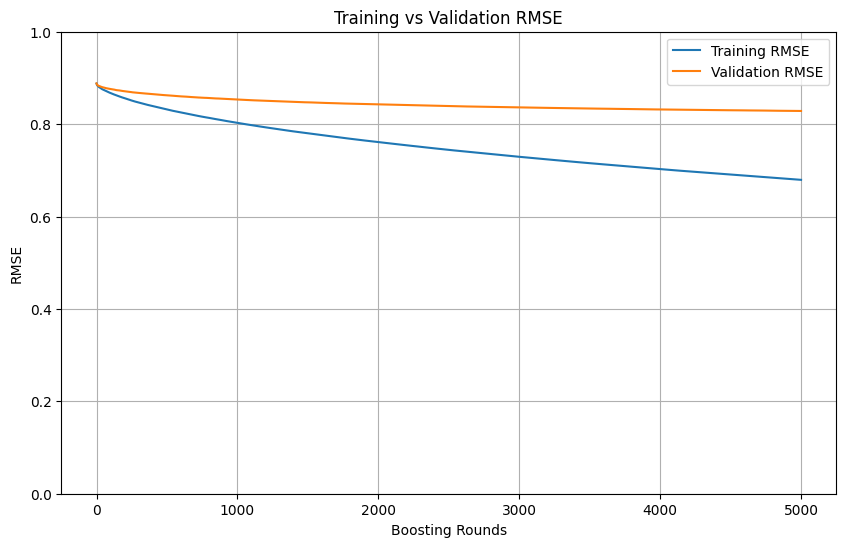

[0]	validation_0-rmse:0.88759	validation_1-rmse:0.88918
[50]	validation_0-rmse:0.87354	validation_1-rmse:0.88000
[100]	validation_0-rmse:0.86648	validation_1-rmse:0.87681
[150]	validation_0-rmse:0.86055	validation_1-rmse:0.87426
[200]	validation_0-rmse:0.85542	validation_1-rmse:0.87226
[250]	validation_0-rmse:0.85072	validation_1-rmse:0.87036
[300]	validation_0-rmse:0.84641	validation_1-rmse:0.86853
[350]	validation_0-rmse:0.84246	validation_1-rmse:0.86726
[400]	validation_0-rmse:0.83863	validation_1-rmse:0.86588
[450]	validation_0-rmse:0.83497	validation_1-rmse:0.86481
[500]	validation_0-rmse:0.83160	validation_1-rmse:0.86381
[550]	validation_0-rmse:0.82824	validation_1-rmse:0.86274
[600]	validation_0-rmse:0.82500	validation_1-rmse:0.86181
[650]	validation_0-rmse:0.82175	validation_1-rmse:0.86072
[700]	validation_0-rmse:0.81871	validation_1-rmse:0.85976
[750]	validation_0-rmse:0.81578	validation_1-rmse:0.85873
[800]	validation_0-rmse:0.81276	validation_1-rmse:0.85773
[850]	validation_

KeyboardInterrupt: 

In [26]:
xgb_train(sample_train_df, sample_y_sr)